In [1]:
import librosa
import numpy as np
import os

In [3]:
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras import models, layers, regularizers, optimizers, callbacks

In [4]:
def normalize_spectrogram(spec):
    # Normalize the spectrogram by subtracting the mean and dividing by the standard deviation
    mean = np.mean(spec)
    std = np.std(spec)
    normalized_spec = (spec - mean) / std
    return normalized_spec

In [5]:
def load_audio_and_extract_spectrogram(audio_file,duration=5, n_mels=128, hop_length=512):

    if not os.path.exists(audio_file):
        print(f"Error: File '{audio_file}' not found.")
        return None
    else:
        try:
            # Load audio file
            y, sr = librosa.load(audio_file,duration=duration)

            # Extract Mel spectrogram
            mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, hop_length=hop_length)
            
          
            # Convert to dB scale
            mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
            #Normalize spectogram
            norm_spectogram=normalize_spectrogram(mel_spectrogram_db)
            
            # Transpose to have time steps as the first dimension (compatible with Conv1D input)
            norm_spectogram = norm_spectogram.T

            return norm_spectogram

        
        except Exception as e:
            print(f"Error encountered while processing '{audio_file}': {e}")
            return None


In [ ]:
def augment_audio(audio, sr, noise_prob=0.5, time_shift_prob=0.5, pitch_shift_prob=0.5, time_stretch_prob=0.5, random_seed=None):
    if random_seed is not None:
        np.random.seed(random_seed)

    augmented_audio = audio.copy()  # Convert to NumPy array if not already
    original_length = len(augmented_audio)

    # Add white noise
    if np.random.rand() < noise_prob:
        augmented_audio += np.random.randn(original_length) * 0.05  # Adjust noise factor as needed

    # Add Gaussian noise
    if np.random.rand() < noise_prob:
        augmented_audio += np.random.normal(0, 1, original_length) * 0.005  # Adjust noise factor as needed

    # Time shifting
    if np.random.rand() < time_shift_prob:
        shift = int(np.random.uniform(-0.5, 0.5) * sr)  # Adjust time shift range as needed
        augmented_audio = np.roll(augmented_audio, shift)
        if shift > 0:
            augmented_audio[:shift] = 0
        else:
            augmented_audio[shift:] = 0
        # Pad or truncate to maintain original length
        augmented_audio = np.pad(augmented_audio, (0, max(0, original_length - len(augmented_audio))), mode='constant')
        augmented_audio = augmented_audio[:original_length]

    # Pitch shifting
    if np.random.rand() < pitch_shift_prob:
        n_steps = np.random.uniform(-2, 2)  # Adjust pitch shift range as needed
        augmented_audio = librosa.effects.pitch_shift(augmented_audio, sr=sr, n_steps=n_steps)

    # Time stretching
    if np.random.rand() < time_stretch_prob:
        rate = np.random.uniform(0.8, 1.2)  # Adjust time stretch range as needed
        stretched_audio = librosa.effects.time_stretch(augmented_audio, rate=rate)
        # Pad or truncate to maintain original length
        augmented_audio = np.pad(stretched_audio, (0, max(0, original_length - len(stretched_audio))), mode='constant')
        augmented_audio = augmented_audio[:original_length]

    return augmented_audio

In [ ]:
def pad_matrix(matrix):
    target_shape = (216, 128)
    
    # Check if the matrix already has the target shape
    if matrix.shape == target_shape:
        return matrix
    
    padded_matrix = np.zeros(target_shape)
    original_shape = matrix.shape
    
    # Calculate padding widths
    pad_width = ((0, target_shape[0] - original_shape[0]), 
                 (0, target_shape[1] - original_shape[1]))
    
    # Pad the matrix
    padded_matrix[:original_shape[0], :original_shape[1]] = matrix
    
    return padded_matrix

In [ ]:
def load_audio_augmented_and_extract_spectrogram(audio_file, duration=5, n_mels=128, hop_length=512):
    if not os.path.exists(audio_file):
        print(f"Error: File '{audio_file}' not found.")
        return None
    else:
        try:
            # Load audio file
            y, sr = librosa.load(audio_file,duration=duration)
            y=augment_audio(y,sr)
            # Extract Mel spectrogram
            mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, hop_length=hop_length)
            # Convert to dB scale
            mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
            #Normalize spectogram
            norm_spectogram=normalize_spectrogram(mel_spectrogram_db)
            # Transpose to have time steps as the first dimension (compatible with Conv1D input)
            norm_spectogram = norm_spectogram.T
            return norm_spectogram
        
        except Exception as e:
            print(f"Error encountered while processing '{audio_file}': {e}")
            return None


In [6]:
import pandas as pd
# Load the Excel file
dataset= pd.read_csv('dataset.csv')
dataset.head()

,Public filename,Interpreter,Song,Interpretation
0,0000.wav,216,Potter,Hum
1,0001.wav,100,Potter,Hum
2,0002.wav,177,Potter,Hum
3,0003.wav,159,Potter,Hum
4,0004.wav,160,Potter,Whistle


In [ ]:
from tqdm import tqdm
def get_data(audio_dataset_path):
    extracted_features=[]
    for index_num,row in tqdm(dataset.iterrows()):
        file_name = os.path.join(audio_dataset_path,str(row["Public filename"]))
        final_class_labels=row["Song"]
        data=load_audio_and_extract_spectrogram(file_name)
        if data is not None:
            extracted_features.append([data,final_class_labels])
    return extracted_features


In [ ]:
extracted_features_train=get_data('audio/')

In [ ]:
#augmentation if need
audio_dataset_path='audio/'
for index_num,row in tqdm(dataset.iterrows()):
    file_name = os.path.join(audio_dataset_path,str(row["Public filename"]))
    final_class_labels=row["Song"]
    data=load_audio_augmented_and_extract_spectrogram(file_name)
    if data is not None:
        data=pad_matrix(data)
        extracted_features_train.append([data,final_class_labels])

In [ ]:
extracted_features_df=pd.DataFrame(extracted_features_train,columns=['feature','class'])
extracted_features_df.head()

In [ ]:
# Split the dataset into independent and dependent dataset
y_train=np.array(extracted_features_df['class'].tolist())
X_train=np.array(extracted_features_df['feature'].tolist())

In [8]:
#y_train=np.load("y_train.npy")
#X_train=np.load("X_train.npy")

In [10]:
y_train

array(['Potter', 'Potter', 'Potter', ..., 'Frozen', 'Frozen', 'Frozen'],
      dtype='<U8')

In [11]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y_train=to_categorical(labelencoder.fit_transform(y_train))

In [12]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [ ]:
extracted_features_test=get_data('test/')

In [ ]:
extracted_features_test_df=pd.DataFrame(extracted_features_test,columns=['feature','class'])
extracted_features_test_df.head()

In [ ]:
y_test=np.array(extracted_features_test_df['class'].tolist())
X_test=np.array(extracted_features_test_df['feature'].tolist())

In [13]:
#y_test=np.load("y_test.npy")

In [14]:
#X_test=np.load("x_test.npy")

In [15]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y_test=to_categorical(labelencoder.fit_transform(y_test))

In [13]:
# Print the shapes to verify
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (11610, 216, 128)
X_test shape: (798, 216, 128)
y_train shape: (11610, 8)
y_test shape: (798, 8)


In [16]:
input_shape = X_train[0].shape  # Shape should be (timesteps, features)
input_shape

(216, 128)

In [30]:
model_1 = models.Sequential([
    layers.Conv1D(32, 3, activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.MaxPooling1D(2),
    layers.Dropout(0.3),
    layers.Conv1D(64, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(2),
    layers.Dropout(0.3),
    layers.Conv1D(128, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(2),
    layers.Dropout(0.3),    
    layers.Reshape((-1, 128)),  # Reshape the output of the Conv1D layers for LSTM input
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),  # Bidirectional LSTM layer
    layers.Bidirectional(layers.LSTM(32)),  # Another Bidirectional LSTM layer
    layers.Dense(128, activation='relu'),
    layers.Dense(8, activation='softmax')  # num_classes is the number of unique song names
])

In [31]:
# Print a summary of the model architecture
model_1.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_21 (Conv1D)                   │ (None, 214, 32)             │          12,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 214, 32)             │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_21 (MaxPooling1D)      │ (None, 107, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 107, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_22 (Conv1D)                   │ (None, 105, 64)             │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 105, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_22 (MaxPooling1D)      │ (None, 52, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 52, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_23 (Conv1D)                   │ (None, 50, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 50, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_23 (MaxPooling1D)      │ (None, 25, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 25, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_7 (Reshape)                  │ (None, 25, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_14 (Bidirectional)     │ (None, 25, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_15 (Bidirectional)     │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 193,512 (755.91 KB)

 Trainable params: 193,064 (754.16 KB)

 Non-trainable params: 448 (1.75 KB)

In [32]:
# Train the model
# optimizer and learning rate
optimizer = optimizers.Adam(learning_rate=0.001)

# Compile the model
model_1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Implement early stopping and reduce learning rate on plateau
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)


# Train the model
history = model_1.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test),
                      callbacks=[early_stopping, reduce_lr])

# Evaluate the model on the test set
test_loss, test_accuracy = model_1.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)

Epoch 1/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 26s 80ms/step - accuracy: 0.2561 - loss: 1.9168 - val_accuracy: 0.5752 - val_loss: 1.2179 - learning_rate: 0.0010
Epoch 2/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - accuracy: 0.5722 - loss: 1.2426 - val_accuracy: 0.6779 - val_loss: 0.9244 - learning_rate: 0.0010
Epoch 3/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - accuracy: 0.6665 - loss: 0.9709 - val_accuracy: 0.7494 - val_loss: 0.7620 - learning_rate: 0.0010
Epoch 4/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - accuracy: 0.7226 - loss: 0.7975 - val_accuracy: 0.7820 - val_loss: 0.6278 - learning_rate: 0.0010
Epoch 5/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - accuracy: 0.7666 - loss: 0.6925 - val_accuracy: 0.7820 - val_loss: 0.6617 - learning_rate: 0.0010
Epoch 6/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.7795 - loss: 0.6465 - val_accuracy: 0.8133 - val_loss: 0.5666 - learning_rate: 0.0010
Epoch 7/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - accuracy: 0.8

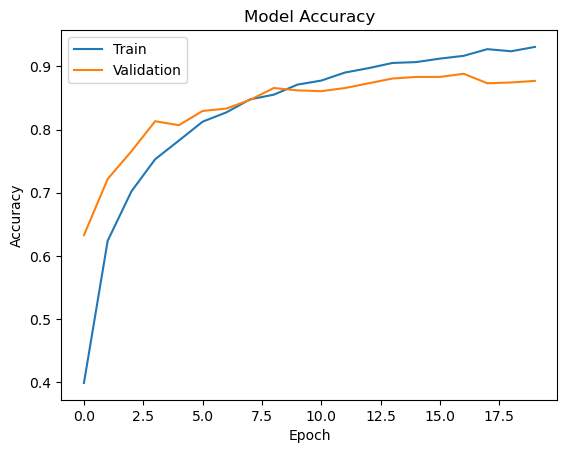

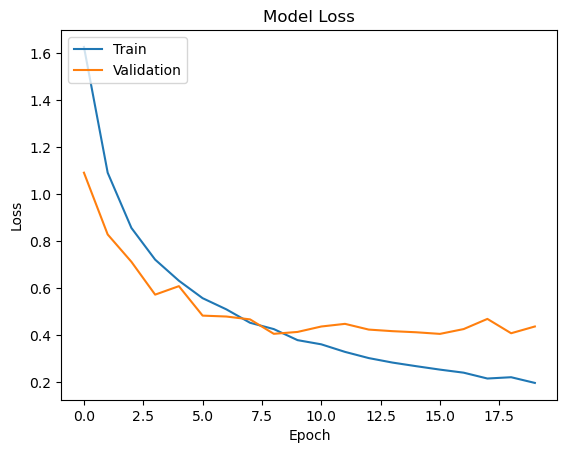

In [32]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [44]:
# Save the trained model to a file
model_1.save('CNN_LSTM_model.h5')

In [14]:
test_spectogram=load_audio_and_extract_spectrogram('recorded_audio.wav')

In [15]:
test_spectogram= np.expand_dims(test_spectogram, axis=0) 

In [16]:
test_spectogram.shape

(1, 216, 128)

In [ ]:
y_decoded = np.argmax(model_1.predict(X_test[0:100]), axis=1)  # Get the index of the highest value in each row
y_original_predict = labelencoder.inverse_transform(y_decoded)

In [70]:
y_decoded_test = np.argmax(y_test[0:100], axis=1)  # Get the index of the highest value in each row
y_original_test = labelencoder.inverse_transform(y_decoded_test)

In [71]:
y_original_predict

array(['Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'StarWars', 'Frozen', 'Hakuna', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Panther', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'StarWars', 'Potter', 'Potter', 'Potter', 

In [72]:
y_original_test

array(['Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Pott

In [27]:
model_2 = models.Sequential([
    layers.Conv1D(64, 5, activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.MaxPooling1D(2),
    layers.Dropout(0.3),
    layers.Conv1D(128, 5, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(2),
    layers.Dropout(0.3),
    layers.Conv1D(256, 5, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(2),
    layers.Dropout(0.3),    layers.Reshape((-1, 128)),  # Reshape the output of the Conv1D layers for LSTM input
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),  # Bidirectional LSTM layer
    layers.Bidirectional(layers.LSTM(32)),  # Another Bidirectional LSTM layer
    layers.Dense(128, activation='relu'),
    layers.Dense(8, activation='softmax')  # num_classes is the number of unique song names
])

In [28]:
 #Compile the model
model_2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print a summary of the model architecture
model_2.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_18 (Conv1D)                   │ (None, 212, 64)             │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 212, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_18 (MaxPooling1D)      │ (None, 106, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 106, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_19 (Conv1D)                   │ (None, 102, 128)            │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 102, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_19 (MaxPooling1D)      │ (None, 51, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 51, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_20 (Conv1D)                   │ (None, 47, 256)             │         164,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 47, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_20 (MaxPooling1D)      │ (None, 23, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 23, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_6 (Reshape)                  │ (None, 46, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_12 (Bidirectional)     │ (None, 46, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_13 (Bidirectional)     │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 397,384 (1.52 MB)

 Trainable params: 396,488 (1.51 MB)

 Non-trainable params: 896 (3.50 KB)

In [29]:
# Train the model
# optimizer and learning rate
optimizer = optimizers.Adam(learning_rate=0.001)

# Compile the model
model_2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Implement early stopping and reduce learning rate on plateau
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)


# Train the model
history = model_2.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test),
                      callbacks=[early_stopping, reduce_lr])

# Evaluate the model on the test set
test_loss, test_accuracy = model_2.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)

Epoch 1/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 52s 173ms/step - accuracy: 0.2904 - loss: 1.8603 - val_accuracy: 0.5865 - val_loss: 1.1946 - learning_rate: 0.0010
Epoch 2/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 26s 140ms/step - accuracy: 0.5704 - loss: 1.2112 - val_accuracy: 0.6729 - val_loss: 0.9339 - learning_rate: 0.0010
Epoch 3/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 25s 138ms/step - accuracy: 0.6649 - loss: 0.9828 - val_accuracy: 0.7343 - val_loss: 0.8166 - learning_rate: 0.0010
Epoch 4/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 26s 139ms/step - accuracy: 0.7187 - loss: 0.8230 - val_accuracy: 0.7744 - val_loss: 0.6949 - learning_rate: 0.0010
Epoch 5/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 25s 138ms/step - accuracy: 0.7616 - loss: 0.7065 - val_accuracy: 0.8058 - val_loss: 0.6245 - learning_rate: 0.0010
Epoch 6/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 26s 143ms/step - accuracy: 0.7840 - loss: 0.6273 - val_accuracy: 0.7832 - val_loss: 0.6539 - learning_rate: 0.0010
Epoch 7/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 25s 136ms/step - accura

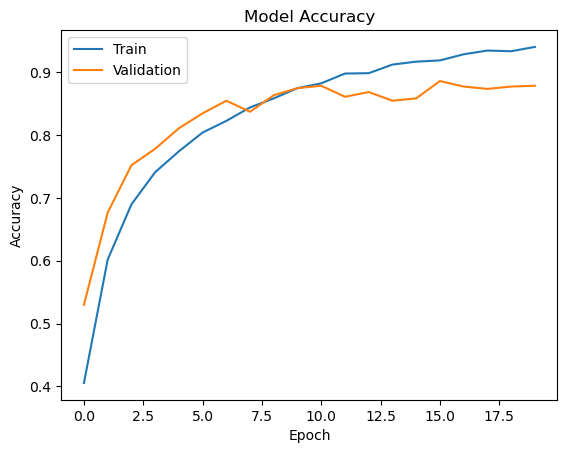

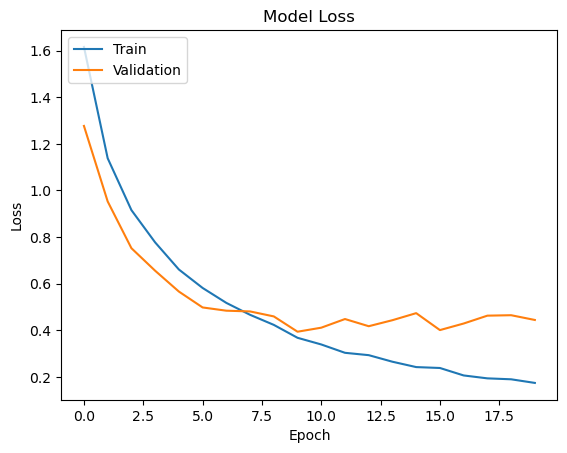

In [82]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [42]:
y_decoded = np.argmax(model_1.predict(X_test[0:100]), axis=1)  # Get the index of the highest value in each row
y_original_predict = labelencoder.inverse_transform(y_decoded)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


In [43]:
y_decoded_test = np.argmax(y_test[0:100], axis=1)  # Get the index of the highest value in each row
y_original_test = labelencoder.inverse_transform(y_decoded_test)

In [45]:
y_original_predict

array(['Potter', 'Potter', 'Potter', 'StarWars', 'Potter', 'Potter',
       'Potter', 'Potter', 'Frozen', 'Potter', 'Frozen', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Frozen', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Rain', 'Potter', 'Potter',
       'StarWars', 'Rain', 'Potter', 'Potter', 'Potter', 'Potter',
       'Showman', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Frozen', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Hakuna', 'Potter', 'Potter', 'Potter', 'Potter', 'Rain',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'StarWars',
       'Potter', 'Potter', 'Potter', 'Rai

In [81]:
y_original_test

array(['Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Pott

In [17]:
model_3 = models.Sequential([
    layers.Conv1D(64, 5, activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.MaxPooling1D(2),
    layers.Dropout(0.2),  
    layers.Conv1D(128, 5, activation='leaky_relu'),  
    layers.BatchNormalization(),
    layers.MaxPooling1D(2),
    layers.Dropout(0.2),
    layers.Conv1D(256, 5, activation='leaky_relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(2),
    layers.Dropout(0.2),
    layers.Reshape((-1, 256)),  # Adjust the reshape layer
    layers.Bidirectional(layers.LSTM(128, return_sequences=True)),  
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dense(256, activation='relu'),
    layers.Dense(8, activation='softmax')  # num_classes is the number of unique song names
])


C:\Users\barra\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
model_3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 212, 64)             │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 212, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 106, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 106, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 102, 128)            │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 102, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 51, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 51, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 47, 256)             │         164,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 47, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 23, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 23, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 23, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 23, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 841,672 (3.21 MB)

 Trainable params: 840,776 (3.21 MB)

 Non-trainable params: 896 (3.50 KB)

In [19]:
# Train the model
# optimizer and learning rate
optimizer = optimizers.Adam(learning_rate=0.001)

# Compile the model
model_3.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Implement early stopping and reduce learning rate on plateau
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)


# Train the model
history = model_3.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test),
                      callbacks=[early_stopping, reduce_lr])

# Evaluate the model on the test set
test_loss, test_accuracy = model_3.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)

Epoch 1/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 53s 197ms/step - accuracy: 0.3665 - loss: 1.6910 - val_accuracy: 0.6742 - val_loss: 0.9175 - learning_rate: 0.0010
Epoch 2/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 34s 181ms/step - accuracy: 0.6754 - loss: 0.9375 - val_accuracy: 0.7820 - val_loss: 0.6743 - learning_rate: 0.0010
Epoch 3/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 34s 182ms/step - accuracy: 0.7661 - loss: 0.6860 - val_accuracy: 0.7857 - val_loss: 0.6234 - learning_rate: 0.0010
Epoch 4/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 36s 196ms/step - accuracy: 0.8107 - loss: 0.5577 - val_accuracy: 0.8296 - val_loss: 0.5308 - learning_rate: 0.0010
Epoch 5/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 32s 173ms/step - accuracy: 0.8528 - loss: 0.4345 - val_accuracy: 0.8434 - val_loss: 0.5209 - learning_rate: 0.0010
Epoch 6/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 32s 176ms/step - accuracy: 0.8752 - loss: 0.3649 - val_accuracy: 0.8697 - val_loss: 0.4137 - learning_rate: 0.0010
Epoch 7/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 33s 178ms/step - accura

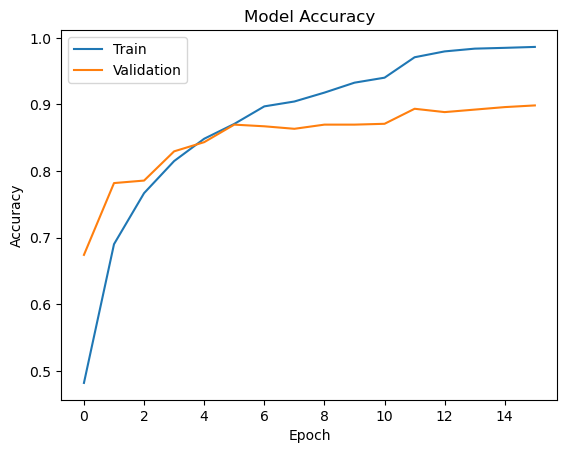

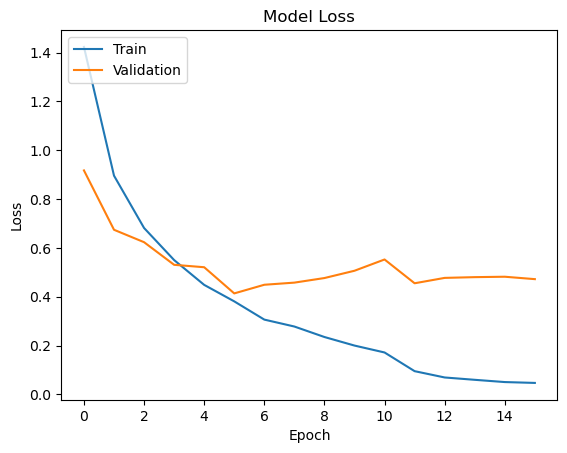

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [35]:
y_decoded = np.argmax(model_3.predict(X_test[0:100]), axis=1)  # Get the index of the highest value in each row
y_original_predict = labelencoder.inverse_transform(y_decoded)

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 443ms/step


In [36]:
y_decoded_test = np.argmax(y_test[0:100], axis=1)  # Get the index of the highest value in each row
y_original_test = labelencoder.inverse_transform(y_decoded_test)

In [37]:
y_original_predict

array(['Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'StarWars', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Hakuna', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Hakuna', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Panther', 'Potter',
       'Potter', 'Potter', 'StarWars', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'StarWars', 'Potter', 'Potter', 'Potter'

In [38]:
y_original_test

array(['Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Pott

In [33]:
# Save the trained model to a file
model_3.save('CNN_LSTM_model_0.9.h5')

In [19]:
# Increase the model capacity and add more layers
model_4 = models.Sequential([
    layers.Conv1D(64, 5, activation='leaky_relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.MaxPooling1D(2),
    layers.Dropout(0.2),
    layers.Conv1D(128, 5, activation='leaky_relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(2),
    layers.Dropout(0.2),
    layers.Conv1D(256, 5, activation='leaky_relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(2),
    layers.Dropout(0.2),
    layers.Reshape((-1, 256)),
    layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),  # Add another dropout layer
    layers.Dense(256, activation='relu'),
    layers.Dense(8, activation='softmax')  # num_classes is the number of unique song names
])

# Use a different optimizer and learning rate
optimizer = optimizers.Adam(learning_rate=0.001)

# Compile the model
model_4.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Implement early stopping and reduce learning rate on plateau
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)


# Train the model
history = model_4.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test),
                      callbacks=[early_stopping, reduce_lr])

# Evaluate the model on the test set
test_loss, test_accuracy = model_4.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)

Epoch 1/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 53s 188ms/step - accuracy: 0.3273 - loss: 1.7539 - val_accuracy: 0.6604 - val_loss: 1.0599 - learning_rate: 0.0010
Epoch 2/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 30s 164ms/step - accuracy: 0.6437 - loss: 1.0319 - val_accuracy: 0.7531 - val_loss: 0.7517 - learning_rate: 0.0010
Epoch 3/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 30s 166ms/step - accuracy: 0.7312 - loss: 0.7803 - val_accuracy: 0.7995 - val_loss: 0.6078 - learning_rate: 0.0010
Epoch 4/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 30s 164ms/step - accuracy: 0.7917 - loss: 0.5995 - val_accuracy: 0.8158 - val_loss: 0.5406 - learning_rate: 0.0010
Epoch 5/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 31s 166ms/step - accuracy: 0.8274 - loss: 0.5165 - val_accuracy: 0.8434 - val_loss: 0.5213 - learning_rate: 0.0010
Epoch 6/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 30s 166ms/step - accuracy: 0.8583 - loss: 0.4213 - val_accuracy: 0.8484 - val_loss: 0.4958 - learning_rate: 0.0010
Epoch 7/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 30s 164ms/step - accura

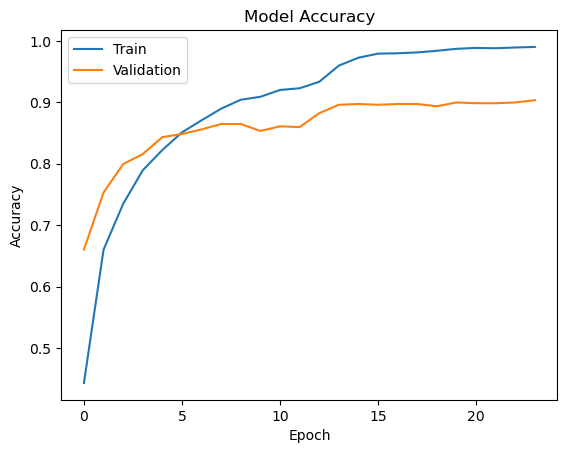

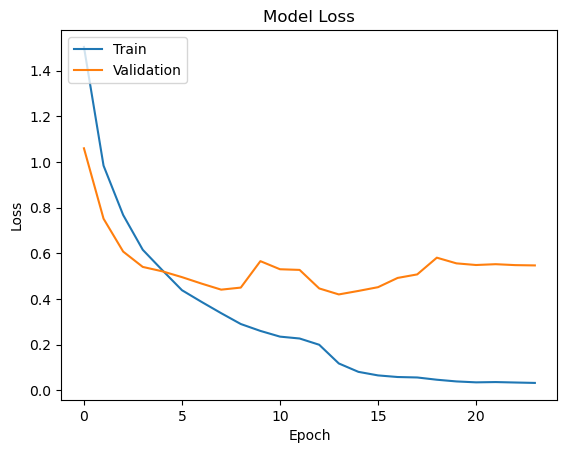

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [39]:
y_decoded = np.argmax(model_4.predict(X_test[0:100]), axis=1)  # Get the index of the highest value in each row
y_original_predict = labelencoder.inverse_transform(y_decoded)

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001FC3B177420> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step 


In [40]:
y_decoded_test = np.argmax(y_test[100:200], axis=1)  # Get the index of the highest value in each row
y_original_test = labelencoder.inverse_transform(y_decoded_test)

In [41]:
y_original_predict

array(['Potter', 'Potter', 'Potter', 'Mamma', 'Potter', 'Potter',
       'Potter', 'Potter', 'StarWars', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Mamma', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Rain', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Showman', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potter', 'Potter',
       'Potter', 'Potter', 'Potter', 'Potter', 'Potte